In [32]:
# 加载数据
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
dataFile = './IVa/100Hz/data_set_IVa_aa.mat'
rawData = sio.loadmat(dataFile)

# 使用简化版数据，采样率仅100Hz(原始采样率为1000Hz)
sampleRate = 100
channelNb = 118

# cnt为298458x118的矩阵，对应100Hz采样，2984.58秒的采样值。
# print(data['cnt'])

# mrk为事件信息，[0][0][0]为事件的发生时间，[0][0][1]为对应的2分类标记(含NaN，作为测试集)，[0][0][2]为分类名称(似乎有误)
# print(rawData['mrk'][0][0][2])

# 对比BCI Competition II Data set III：
#        III    IVa
# trial  定长  不定长
# 通道数   3    118

In [33]:
# 转np.array便于处理
rawMat = np.array(rawData['cnt'])
rawMat_tr=rawMat.T
print(type(rawMat),type(rawData))
print(rawMat.shape,rawMat_tr.shape)

<class 'numpy.ndarray'> <class 'dict'>
(298458, 118) (118, 298458)


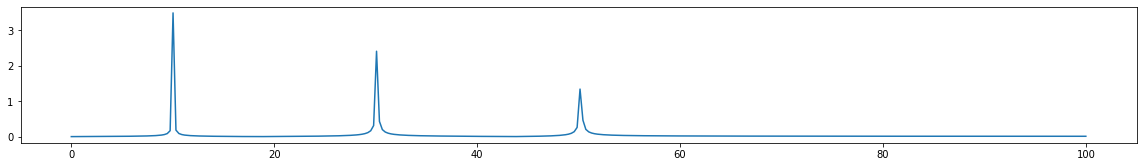

In [34]:
# 求频域特征
from scipy.fftpack import fft
 
def myFFT(data,sampRate):
    N=len(data)
    fData=fft(data)
    fData=np.abs(fData)
    fData=fData/N
    fData=fData[range(int(N/2))]
    return fData

def plotFFT(data,sampRate,index=1):
    x=np.linspace(0,sampRate/2,len(data))

    plt.figure(figsize=(20,channelNb*3)) # 指定图像大小
    subGraph=plt.subplot(channelNb,1,index)
    subGraph.plot(x,data)

def FFTDemo():
    T=3.5
    Fs=200
    x=np.linspace(0,T,int(T*Fs))      
    y=7*np.sin(2*np.pi*10*x) + 5*np.sin(2*np.pi*30*x)+3*np.sin(2*np.pi*50*x)

    ff=myFFT(y,Fs)
    plotFFT(ff,Fs)
FFTDemo()

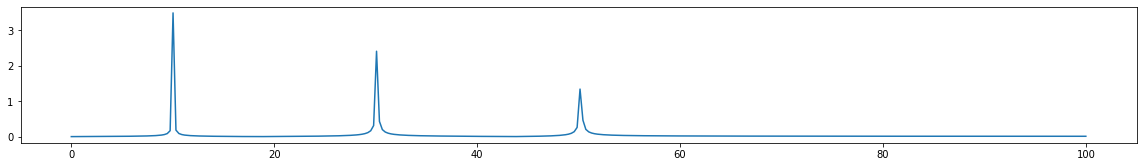

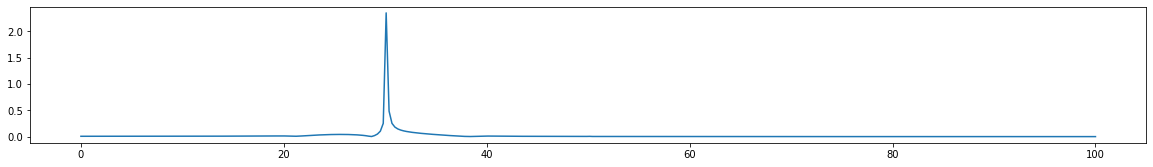

In [35]:
# 滤波器
import scipy.signal as signal
import math
from scipy.signal import butter, lfilter
from scipy.fftpack import fft

def butterWorthFilter(data,passBand,type,sampRate,order=10):
    sos=butter(N=order,Wn=passBand,btype=type,fs=sampRate,output="sos")
    return signal.sosfilt(sos,data)

def butterWorthDemo():
    T=3.5
    Fs=200
    x=np.linspace(0,T,int(T*Fs)) 
    fx=np.linspace(0,T,int(T*Fs/2))
    y=7*np.sin(2*np.pi*10*x) + 5*np.sin(2*np.pi*30*x)+3*np.sin(2*np.pi*50*x)

    ff=myFFT(y,Fs)
    plotFFT(ff,Fs)
    
    filterY=butterWorthFilter(y,[20,40],'bandpass',Fs)
    filterFF=myFFT(filterY,Fs)
    plotFFT(filterFF,Fs,2)

    # plt.figure(figsize=(20,channelNb*3)) # 指定图像大小
    
    # ax1=plt.subplot(channelNb,1,1)
    # ax1.plot(xx,ff)
    # ax2=plt.subplot(channelNb,1,2)
    # ax2.plot(xx,filterFF)
    
butterWorthDemo()

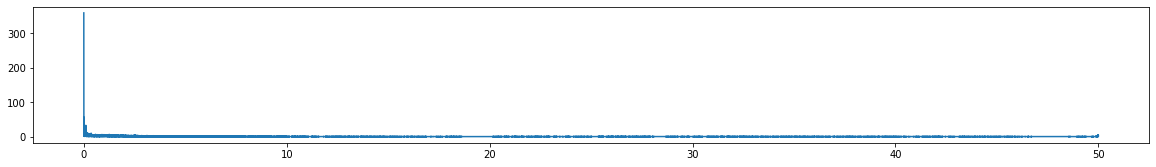

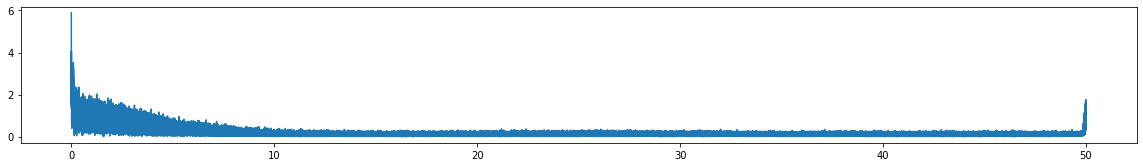

In [36]:
# 尝试使用log在频谱中放大小幅值频率
ff_raw0=myFFT(rawMat_tr[0],sampleRate)
fflog_raw0=np.log(ff_raw0+1)

plotFFT(ff_raw0,sampleRate)
plotFFT(fflog_raw0,sampleRate)

(1, 5059)


array([[3236, 3275, 2883, ..., -275, -239,  -84]], dtype=int16)

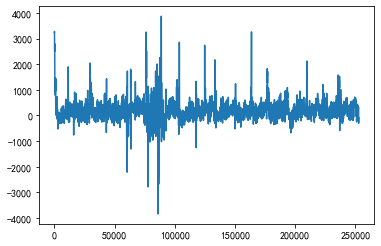

In [163]:
# 绘图
import matplotlib.pyplot as plt

# 绘制部分通道/部分点，便于预览
def channelPlot(data,targetRange,dotNb=300):
    # 数据取样
    newData=[]
    oriLen=data.shape[1]
    for i in targetRange:
        subData=[]
        for j in range(0,oriLen,oriLen//dotNb):
            subData.append(data[i][j])
        newData.append(subData)

    # 绘图
    newArray=np.array(newData)
    print(newArray.shape)
    xAxis=np.linspace(0,newArray.shape[1]//(sampleRate/dotNb),newArray.shape[1])
    graphList=[]
    for i in range (len(targetRange)):
        graphList.append(plt.subplot(len(targetRange),1,i+1))
        plt.sca(graphList[-1])
        plt.plot(xAxis,newArray[i])
    return newArray

channelPlot(rawMat_tr,range(20,21),5000)

In [37]:
# 根据老师提供的信息，仅对运动区进行处理
# 根据运动区的节点名字获取节点编号
nodeList=rawData['nfo'][0][0][2][0]
motionNodeNameList=['FCZ','FC1','FC2','FC3','FC4','CZ','C1','C2','C3','C4','CPZ','CP1','CP2','CP3','CP4']
motionNodeList=[]
for i,node in enumerate(nodeList):
    for motionName in motionNodeNameList:
        name=node[0]
        if name.upper() == motionName.upper():
            motionNodeList.append((i,str(name)))
print(motionNodeList)


[(33, 'FC3'), (34, 'FC1'), (35, 'FCz'), (36, 'FC2'), (37, 'FC4'), (51, 'C3'), (52, 'C1'), (53, 'Cz'), (54, 'C2'), (55, 'C4'), (69, 'CP3'), (70, 'CP1'), (71, 'CPz'), (72, 'CP2'), (73, 'CP4')]


(15, 298458)


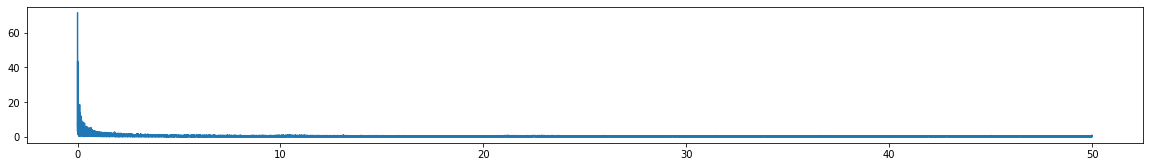

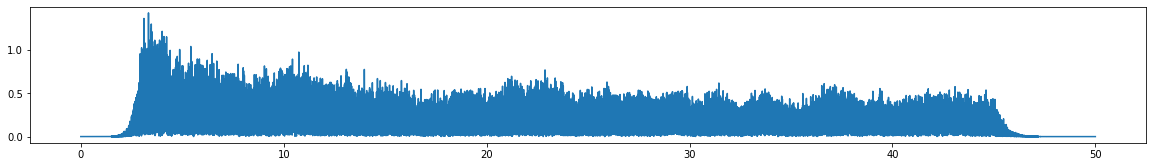

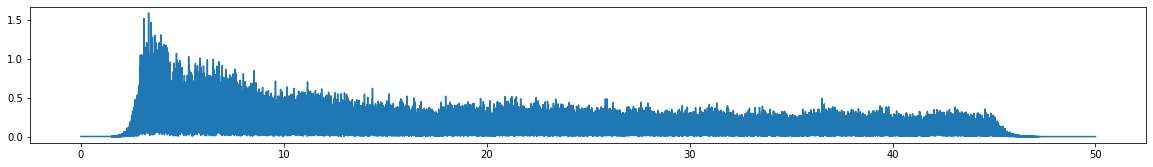

In [73]:
# 对每个通道进行预滤波，将直流分量去除

# 测试部分，以通道50为例，可发现直流分量被明显滤去
plotFFT(myFFT(rawMat_tr[50],sampleRate),sampleRate)
newData=butterWorthFilter(rawMat_tr[50],[3,45],'bandpass',sampleRate)
plotFFT(myFFT(newData,sampleRate),sampleRate,1)

# 正式处理部分
filterArray=[]
# for i in range(channelNb):
#     filterArray=np.append(filterArray,butterWorthFilter(rawMat_tr[i],[3,45],'bandpass',sampleRate))
# filterMat=np.split(filterArray,channelNb)
for node in motionNodeList:
    filterArray.append(butterWorthFilter(rawMat_tr[node[0]],[3,45],'bandpass',sampleRate))
filterMat=np.array(filterArray)
print(filterMat.shape)

In [75]:
# 按照trial发生时间进行拆分
# 根据资料，Visual cues持续时长为3.5s，对应(3.5*sampleRate)个采样点，之后为1.75~2.25s的休息时间。
# 则每次trial发生后仅取前(3.5*sampleRate)个采样点，解决trial不等间隔的问题
trialDict={}
trialNb=rawData['mrk'][0][0][0].shape[1] # 280
for i in range(trialNb):
    trialDict[rawData['mrk'][0][0][0][0][i]]=rawData['mrk'][0][0][1][0][i]

dataGrp=[]
for i in range(len(motionNodeList)):
    subGrp=[]
    for j in trialDict:
        subGrp.append(filterMat[i][j:j+round(3.5*sampleRate+0.5)])
    dataGrp.append(subGrp)
dataGrp=np.array(dataGrp)
print(dataGrp.shape)

(15, 280, 350)


In [84]:
# 上SVM
from sklearn import svm

print(dataGrp[1][2][0])
dataGrp_t=np.swapaxes(dataGrp, 0, 1)
print(dataGrp)
print(dataGrp_t.shape)

-25.644599148764875
[[[  14.20437833   42.67909736   47.01481414 ...   34.77391325
    -14.12697482  -58.83064482]
  [  40.14310037  -43.49165684   52.71075823 ...  -35.19799568
    -12.40896888   -7.93214029]
  [   1.07389149  -74.28898151 -148.02027162 ...  -44.73850602
    -35.68129725  -40.18337708]
  ...
  [ -61.63959654   39.37356749    3.87350264 ...   56.83290274
    -16.90046849 -141.12732583]
  [  45.93523152   58.40472132  -25.11767192 ...  -52.42277692
    -30.56989505  -21.54282634]
  [ -89.49330279  -11.63200264  -34.12134246 ...   10.29385534
     -5.00875849   16.5145564 ]]

 [[   9.3315252    32.94243979   51.70733954 ...   28.90690463
    -42.59493683  -69.74512318]
  [  45.06872519  -44.28796534   45.58608703 ...  -50.26579622
    -22.32934475  -13.54499251]
  [ -25.64459915  -84.8512497  -150.23206257 ...  -48.38780775
    -51.06467002  -43.97612108]
  ...
  [ -12.32790353   32.63380825   -8.48086491 ...   18.91322884
    -26.8277947  -132.86863046]
  [  47.80616162

In [83]:
print(dataGrp[1][2][0])
print(dataGrp[2][1][0])

-25.644599148764875
54.536324334215806
